In [1]:
#Import standard packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
from sklearn.metrics import r2_score
import pickle
from tqdm import tqdm
import csv
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import decoder functions
from Neural_Decoding.decoders import WienerFilterDecoder

In [2]:
folder='../SR-Task/preprocessed_data/'
#ENTER THE FOLDER THAT YOUR DATA IS IN

with open(folder+'all_data_SR.pickle','rb') as f:
    M1, PMd, M1_PMd,pos_binned,vels_binned=pickle.load(f,encoding='latin1') #If using python 3


In [9]:
## Do preprocessing and run the decoder for M1, PMd, and M1&PMd together 
#neural_data_combined = [M1, PMd, M1_PMd]
neural_data_combined = [M1, M1_PMd]
#kinematics = [pos_binned, vels_binned]
kinematics = [vels_binned]


R2 = np.empty((2,1))
row = 0
for i in tqdm(range(2)):
    neural_data = neural_data_combined[i]
    col = 0
    for output in kinematics:
        # Preprocess data
        bins_before=6 #How many bins of neural data prior to the output are used for decoding
        bins_current=1 #Whether to use concurrent time bin of neural data
        bins_after=0 #How many bins of neural data after the output are used for decoding

        # Format for recurrent neural networks (SimpleRNN, GRU, LSTM)
        # Function to get the covariate matrix that includes spike history from previous bins
        X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

        # Format for Wiener Filter, Wiener Cascade, XGBoost, and Dense Neural Network
        #Put in "flat" format, so each "neuron / time" is a single feature
        X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

        # Output covariates
        #Set decoding output
        y=output
        
        # Split into training / testing / validation sets
        #Set what part of data should be part of the training/testing/validation sets
        training_range=[0,0.7]
        testing_range=[0.7, 0.85]
        valid_range=[0.85, 1]

        # Split data:
        num_examples=X.shape[0]

        #Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
        #This makes it so that the different sets don't include overlapping neural data
        training_set=np.arange(int(np.round(training_range[0]*num_examples))+bins_before,int(np.round(training_range[1]*num_examples))-bins_after)
        testing_set=np.arange(int(np.round(testing_range[0]*num_examples))+bins_before,int(np.round(testing_range[1]*num_examples))-bins_after)
        valid_set=np.arange(int(np.round(valid_range[0]*num_examples))+bins_before,int(np.round(valid_range[1]*num_examples))-bins_after)

        #Get training data
        X_train=X[training_set,:,:]
        X_flat_train=X_flat[training_set,:]
        y_train=y[training_set,:]

        #Get testing data
        X_test=X[testing_set,:,:]
        X_flat_test=X_flat[testing_set,:]
        y_test=y[testing_set,:]

        #Get validation data
        X_valid=X[valid_set,:,:]
        X_flat_valid=X_flat[valid_set,:]
        y_valid=y[valid_set,:]
        
        # Process covariates
        #Z-score "X" inputs. 
        X_train_mean=np.nanmean(X_train,axis=0)
        X_train_std=np.nanstd(X_train,axis=0)
        X_train=(X_train-X_train_mean)/X_train_std
        X_test=(X_test-X_train_mean)/X_train_std
        X_valid=(X_valid-X_train_mean)/X_train_std

        #Z-score "X_flat" inputs. 
        X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
        X_flat_train_std=np.nanstd(X_flat_train,axis=0)
        X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
        X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
        X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

        #Zero-center outputs
        y_train_mean=np.mean(y_train,axis=0)
        y_train=y_train-y_train_mean
        y_test=y_test-y_train_mean
        y_valid=y_valid-y_train_mean
        
        # Run decoder
        #Declare model
        model_wf=WienerFilterDecoder()

        #Fit model
        model_wf.fit(X_flat_train,y_train)

        #Get predictions
        y_valid_predicted_wf=model_wf.predict(X_flat_valid)
        
        if i == 0:
            predictions = y_valid_predicted_wf
        else:
            predictions = [predictions, y_valid_predicted_wf]
        
        R2_vw = r2_score(y_valid,y_valid_predicted_wf, multioutput='variance_weighted')
        
        print(R2_vw)
        # Save the R2 value for a given neural data and kinematics
        R2[row,col] = R2_vw
        col += 1
    row += 1

 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  1.41it/s]

0.7052464347472487


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.03s/it]

0.7346940809134993


In [10]:
R2 = np.around(R2, 3)
print(R2)

[[0.705]
 [0.735]]


In [5]:
N_len = len(y_valid[1050:1300,0])
x_init = list(range(N_len))
x = [element*30/1000 for element in x_init]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


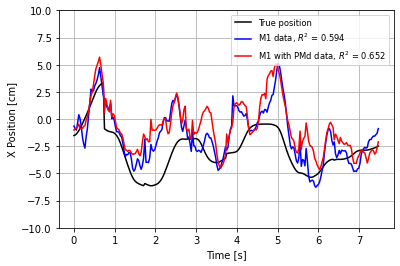

In [6]:
fig_x_wf=plt.figure()
plt.plot(x,y_valid[1050:1300,0],'k',label="True position")
plt.plot(x,predictions[0][1050:1300,0],'b',label="M1 data, $R^2$ = " + str(np.squeeze(R2[0])))
plt.plot(x,predictions[1][1050:1300,0],'r',label="M1 with PMd data, $R^2$ = " + str(np.squeeze(R2[1])))
plt.grid()
#plt.plot(y_valid_predicted_wf[-1-38:,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.legend(loc="upper right", prop = fontP)
plt.xlabel("Time [s]")
plt.ylabel("X Position [cm]")
plt.ylim([-10, 10])
plt.savefig('figures/SR_example_predictions/WF_SR_pos_X.eps', format='eps')
plt.savefig('figures/SR_example_predictions/WF_SR_pos_X.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


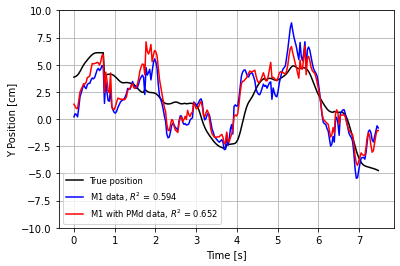

In [7]:
fig_x_wf=plt.figure()
plt.plot(x,y_valid[1050:1300,1],'k',label="True position")
plt.plot(x,predictions[0][1050:1300,1],'b',label="M1 data, $R^2$ = " + str(np.squeeze(R2[0])))
plt.plot(x,predictions[1][1050:1300,1],'r',label="M1 with PMd data, $R^2$ = " + str(np.squeeze(R2[1])))
plt.grid()
#plt.plot(y_valid_predicted_wf[-1-38:,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.legend(loc="lower left", prop = fontP)
plt.ylim([-10, 10])
plt.xlabel("Time [s]")
plt.ylabel("Y Position [cm]")
plt.savefig('figures/SR_example_predictions/WF_SR_pos_Y.eps', format='eps')
plt.savefig('figures/SR_example_predictions/WF_SR_pos_Y.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


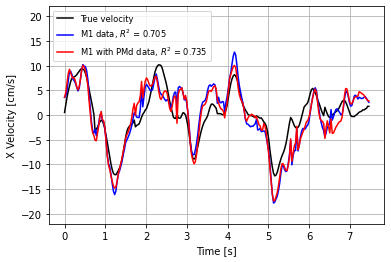

In [11]:
fig_x_wf=plt.figure()
plt.plot(x,y_valid[1050:1300,0],'k',label="True velocity")
plt.plot(x,predictions[0][1050:1300,0],'b',label="M1 data, $R^2$ = " + str(np.squeeze(R2[0])))
plt.plot(x,predictions[1][1050:1300,0],'r',label="M1 with PMd data, $R^2$ = " + str(np.squeeze(R2[1])))
plt.grid()
#plt.plot(y_valid_predicted_wf[-1-38:,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.legend(loc="upper left", prop = fontP)
plt.xlabel("Time [s]")
plt.ylabel("X Velocity [cm/s]")
plt.ylim([-22, 22])

plt.savefig('figures/SR_example_predictions/WF_SR_vel_X.eps', format='eps')
plt.savefig('figures/SR_example_predictions/WF_SR_vel_X.png')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


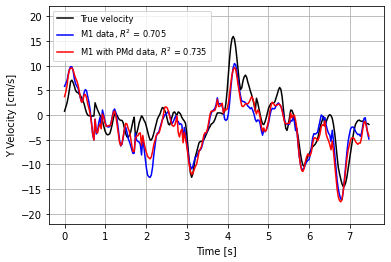

In [12]:
fig_x_wf=plt.figure()
plt.plot(x,y_valid[1050:1300,1],'k',label="True velocity")
plt.plot(x,predictions[0][1050:1300,1],'b',label="M1 data, $R^2$ = " + str(np.squeeze(R2[0])))
plt.plot(x,predictions[1][1050:1300,1],'r',label="M1 with PMd data, $R^2$ = " + str(np.squeeze(R2[1])))
plt.grid()
#plt.plot(y_valid_predicted_wf[-1-38:,0]+y_train_mean[0],'r', label="Predicted velocity")
plt.legend(loc="upper left", prop = fontP)
plt.xlabel("Time [s]")
plt.ylabel("Y Velocity [cm/s]")
plt.ylim([-22, 22])
plt.savefig('figures/SR_example_predictions/WF_SR_vel_y.eps', format='eps')
plt.savefig('figures/SR_example_predictions/WF_SR_vel_y.png')
plt.show()